# Airbnb Raings Prediction

#### :Predict the ratings of Airbnb rooms with regression methods.
#### (Final project for 'Introduction To Business Analytics', BIZ3197-01)





## 1. Data Preprocessing

In [81]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/listings.csv")

C:\Users\space\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(50796, 106)

---
- ### Delete unnecessary variables
    : Delete the variables which has NO causal realtionship with ratings
---

In [4]:
drop_cols = ['thumbnail_url', 'medium_url', 'xl_picture_url', 'listing_url',
             'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
             'last_scraped', 'scrape_id', 'host_id',
             'minimum_minimum_nights',
             'maximum_minimum_nights',
             'minimum_maximum_nights',
             'maximum_maximum_nights',
             'experiences_offered',
             'picture_url', 'host_url',
             'host_name', 'host_since', 'host_location', 'host_about',
             'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
             'street',
             'neighbourhood',
             'city',
             'state',
             'zipcode',
             'market',
             'smart_location',
             'country_code',
             'country',
             'calendar_updated',
             'calendar_last_scraped',
             'first_review',
             'last_review',
             'cleaning_fee',
             'neighbourhood_cleansed'
            ]

In [5]:
df = df.drop(columns=drop_cols)
print(df.shape)

(50796, 68)


---
- ### Handling missing data
    - Drop the columns which have missing values over 1/4
    - Drop the rows which don't have target variables
    - Fill up the missing values
        - Categorical data -> use mode
        - Numerical data -> use median
---

In [6]:
miss = df.isnull().sum().to_frame()
miss.columns = ['missing_num']
miss['missing_%'] = np.round(100 * (miss['missing_num'] / df.shape[0]))
miss.sort_values(by='missing_num', ascending=False, inplace=True)
miss[miss['missing_%']>0]

,missing_num,missing_%
jurisdiction_names,50781,100.0
license,50759,100.0
square_feet,50407,99.0
monthly_price,46119,91.0
weekly_price,45411,89.0
notes,30273,60.0
access,23984,47.0
interaction,20436,40.0
house_rules,19860,39.0
host_response_time,19006,37.0


In [7]:
drop_col = list(miss[miss['missing_%'] >= 25].index)
df = df.drop(drop_col, axis='columns')
print(df.shape)

(50796, 52)


In [15]:
df = df[lambda x: x.review_scores_rating.isna() == False]
df.shape

(37927, 52)

In [16]:
category_missing_cols = ['host_has_profile_pic', 'host_identity_verified',
                         'host_is_superhost', 'cancellation_policy']

float_missing_cols = ['bathrooms', 'beds', 'bedrooms',
                      'host_total_listings_count',
                      'host_listings_count',
                      'review_scores_value',
                      'review_scores_accuracy',
                      'review_scores_cleanliness',
                      'review_scores_checkin',
                      'review_scores_communication',
                      'review_scores_location',
                      'reviews_per_month']

In [17]:
def replace(cols, df):

    for col in cols:
        
        #Categorical data -> use mode
        #Integer, Float data -> use median
        
        if type(df[col].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
            print("{} -> mode".format(col))
            mode_imputer = SimpleImputer(strategy='most_frequent')
            df.loc[:, col] = mode_imputer.fit_transform(df[[col]])
        elif df[col].dtype == 'float64' or df[col].dtype == 'int64':
            print("{} -> median".format(col))
            median_imputer = SimpleImputer(strategy='median')
            df.loc[:, col] = median_imputer.fit_transform(df[[col]])
        else:
            raise ValueError("Invalid value")

    return df

In [18]:
df_replaced = replace(float_missing_cols, df)
df_replaced = replace(category_missing_cols, df)

bathrooms -> median
beds -> median
bedrooms -> median
host_total_listings_count -> median
host_listings_count -> median
review_scores_value -> median
review_scores_accuracy -> median
review_scores_cleanliness -> median
review_scores_checkin -> median
review_scores_communication -> median
review_scores_location -> median
reviews_per_month -> median
host_has_profile_pic -> mode
host_identity_verified -> mode
host_is_superhost -> mode
cancellation_policy -> mode


In [19]:
df_replaced.isna().sum()

id                                                 0
name                                               7
summary                                         1538
description                                      570
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
is_location_exact                                  0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                          0
bedrooms                                      

In [20]:
df_replaced['price'] = df_replaced.price.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')
df_replaced['extra_people'] = df_replaced.extra_people.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')

---
- ### Handling categorical data
    - Convert data type
    - Choose Categories
    - Create dummy variables
---

In [8]:
category_col = []
for column in df.columns:
    if df[column].dtype == 'object':
        category_col.append(column)
        
category_col = category_col[3:]
category_col.remove('host_verifications')
category_col.remove('amenities')
category_col.remove('price')
category_col.remove('extra_people')
category_col

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'has_availability',
 'requires_license',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [9]:
df[category_col] = df[category_col].apply(lambda x: x.astype('category'), axis='rows')
df[category_col].dtypes

host_is_superhost                   category
host_has_profile_pic                category
host_identity_verified              category
neighbourhood_group_cleansed        category
is_location_exact                   category
property_type                       category
room_type                           category
bed_type                            category
has_availability                    category
requires_license                    category
instant_bookable                    category
is_business_travel_ready            category
cancellation_policy                 category
require_guest_profile_picture       category
require_guest_phone_verification    category
dtype: object

host_is_superhost                    2
host_has_profile_pic                 2
host_identity_verified               2
neighbourhood_group_cleansed         5
is_location_exact                    2
property_type                       40
room_type                            4
bed_type                             5
has_availability                     1
requires_license                     1
instant_bookable                     2
is_business_travel_ready             1
cancellation_policy                  6
require_guest_profile_picture        2
require_guest_phone_verification     2
dtype: int64


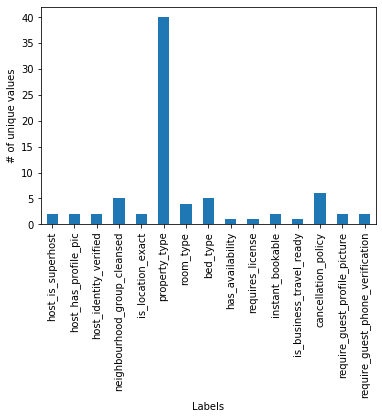

In [10]:
num_unique_values = df[category_col].apply(pd.Series.nunique, axis='rows')
print(num_unique_values)

num_unique_values.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('# of unique values')

plt.show()

In [11]:
df.property_type.value_counts()

Apartment                 39637
House                      4164
Townhouse                  1766
Condominium                1716
Loft                       1376
Serviced apartment          459
Guest suite                 425
Boutique hotel              422
Hotel                       298
Other                       101
Guesthouse                   81
Resort                       75
Bed and breakfast            51
Hostel                       46
Villa                        35
Bungalow                     27
Tiny house                   24
Aparthotel                   17
Camper/RV                    15
Boat                          8
Cottage                       8
Earth house                   7
Tent                          5
Cave                          4
Houseboat                     3
Castle                        3
Casa particular (Cuba)        3
Lighthouse                    2
Dome house                    2
Cabin                         2
Bus                           2
Island  

In [13]:
df = df[df.property_type.isin(['Apartment', 'House', 'Townhouse', 'Condominium', 'Loft'])]
df.loc[:, 'property_type'] = df.loc[:,'property_type'].cat.remove_unused_categories()

In [14]:
print(df.property_type.value_counts())
print(df.shape)

Apartment      39637
House           4164
Townhouse       1766
Condominium     1716
Loft            1376
Name: property_type, dtype: int64
(48659, 52)


In [21]:
category = pd.get_dummies(df_replaced[category_col])
category.head()

,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,...,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
4,1,0,0,1,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
5,1,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
6,1,0,0,1,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0


In [22]:
df = pd.concat([df_replaced, category], axis='columns').drop(category_col, axis='columns')
df.shape

(37927, 79)

In [23]:
df.to_csv("data/airbnb_preprocessed.csv")

## 2. Model Preparing

- ### Multicollinearity assumption check

In [62]:
df = pd.read_csv("data/airbnb_preprocessed.csv", index_col=0)

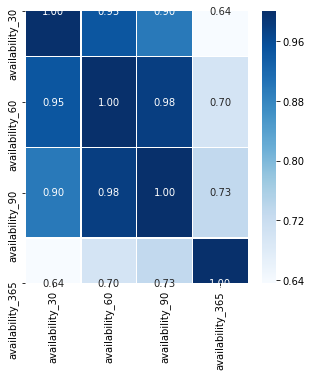

In [63]:
df_avail = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']]
plt.figure(figsize=(5,5))
sns.heatmap(data = df_avail.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

- ### Drop the highly correlated variables

In [64]:
# Variables whose correlation is upper than 0.7

drop_corr = ['has_availability_t','requires_license_f','is_business_travel_ready_f',
           'availability_60', 'availability_90', 'number_of_reviews_ltm',
           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location', 'review_scores_value',
           'calculated_host_listings_count_entire_homes', 'host_total_listings_count', 
           'calculated_host_listings_count', 'calculated_host_listings_count_shared_rooms',
           'calculated_host_listings_count_private_rooms', 'host_verifications', 'amenities' ]

# Variables which are not necessary to the model
drop_noneed = ['latitude', 'longitude', 'id', 'name', 'summary', 'description']
drop_col = drop_corr + drop_noneed

df.drop(columns=drop_col, inplace=True)
df.shape

(37927, 54)

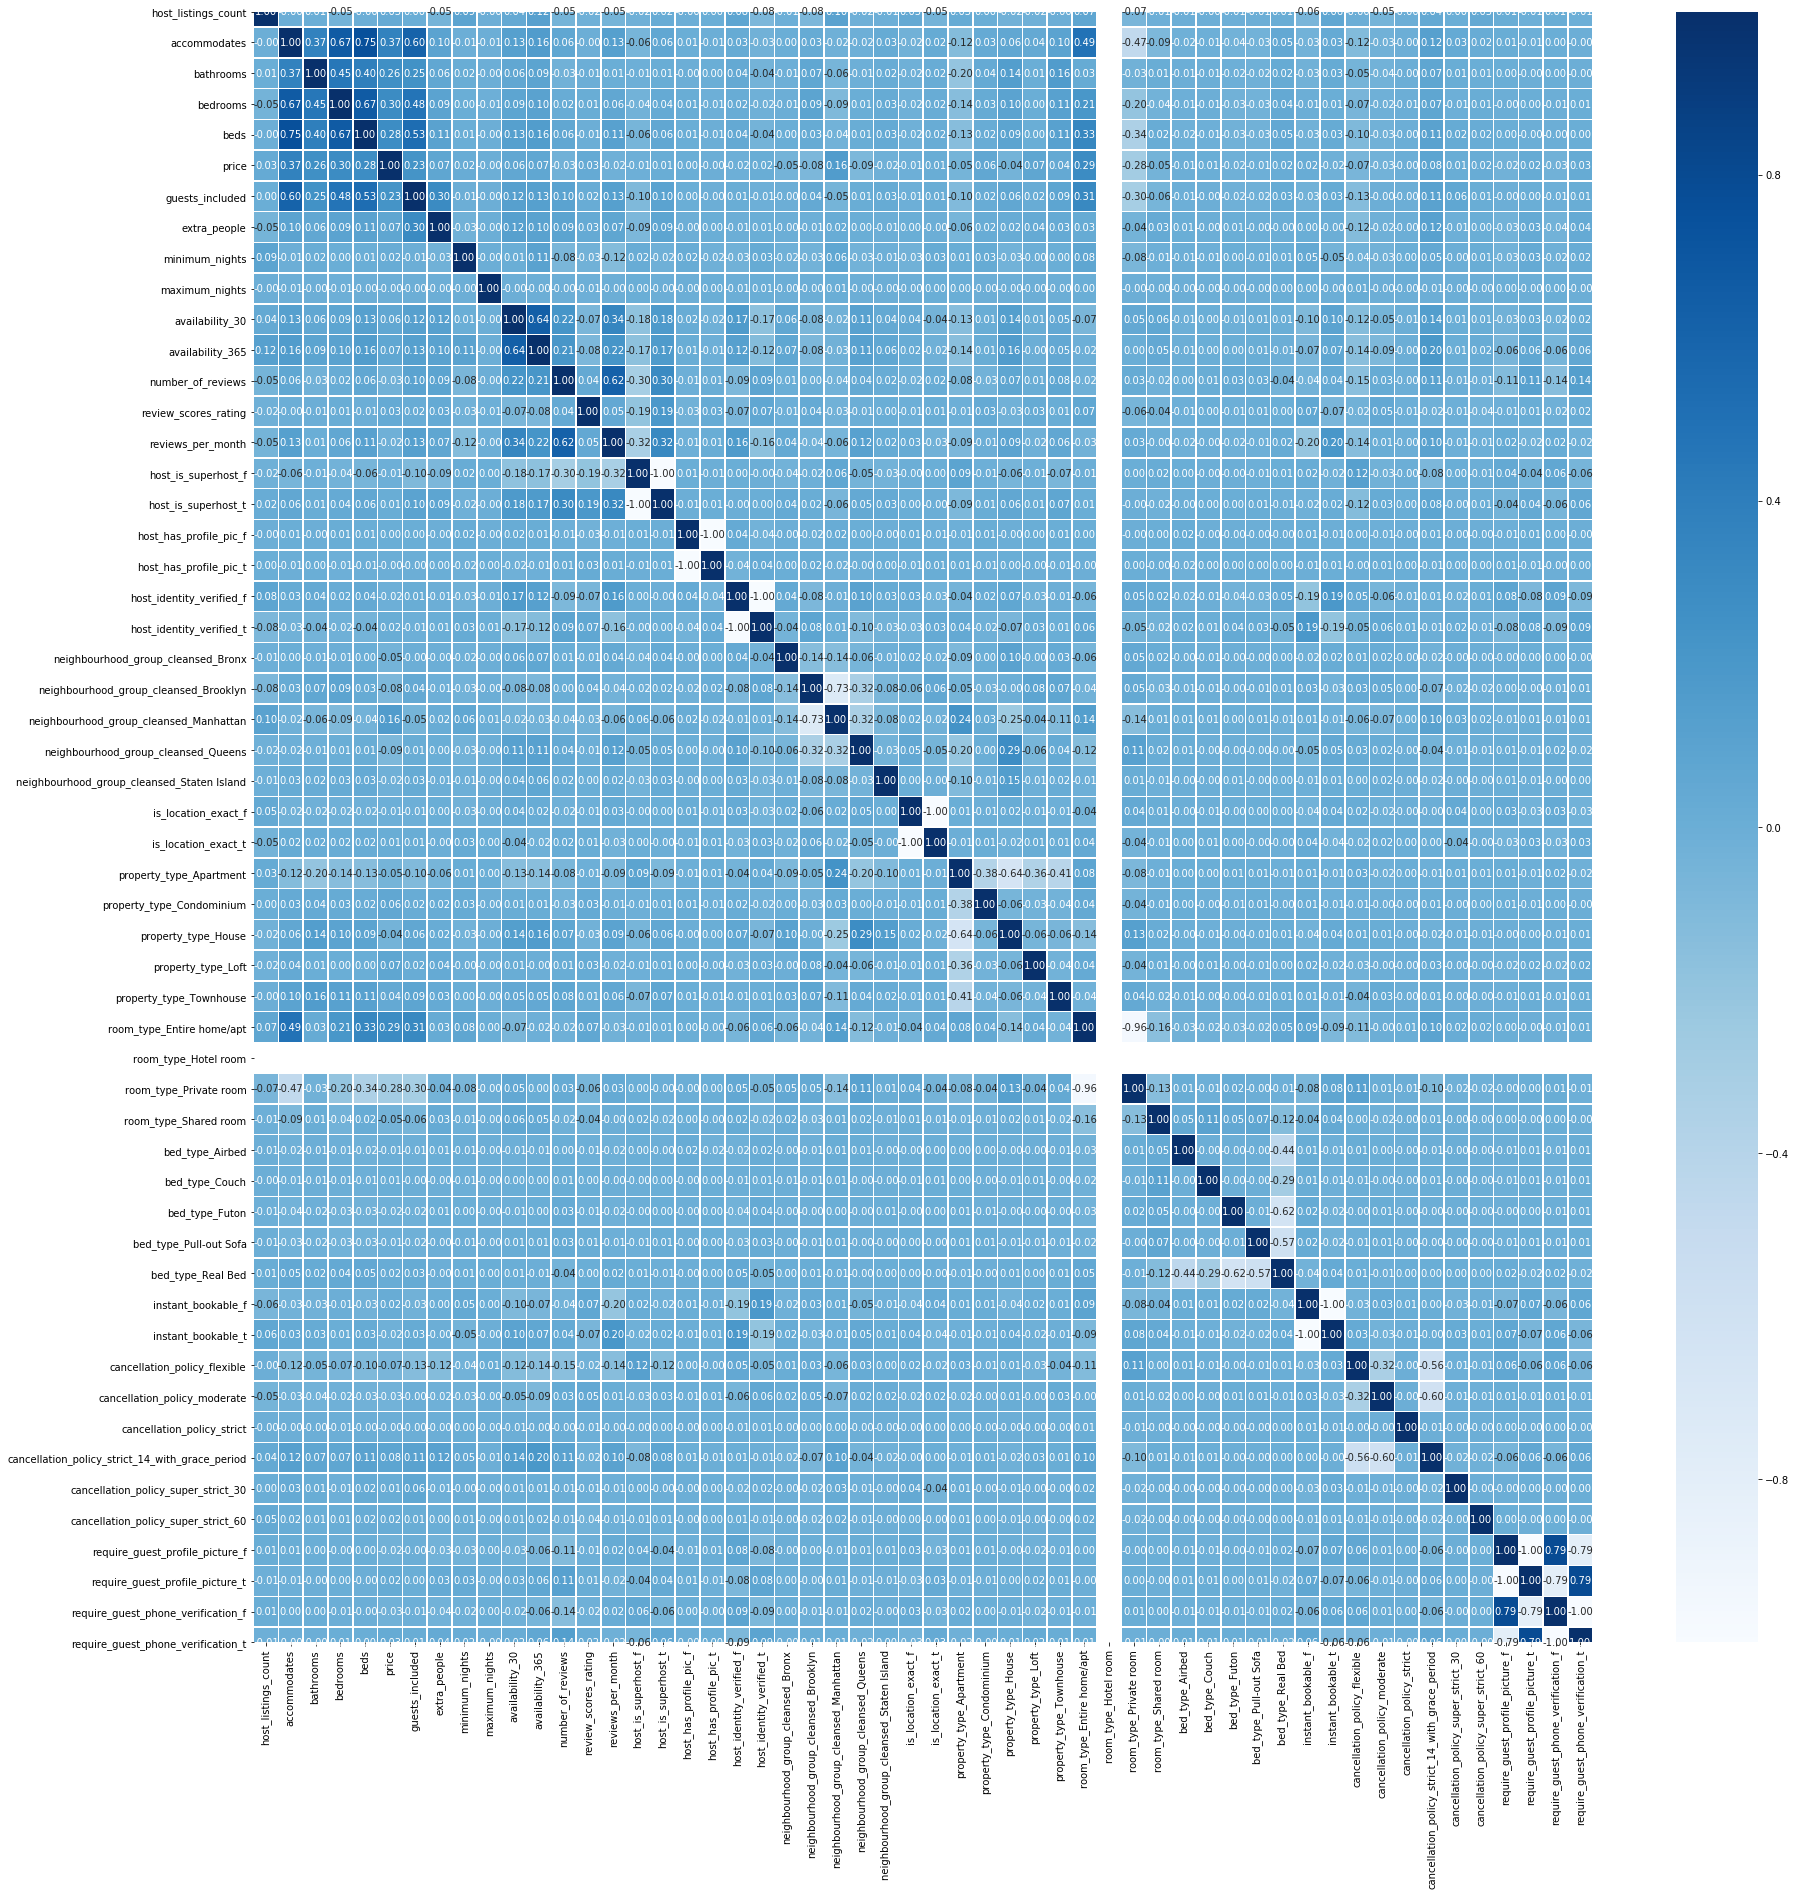

In [65]:
plt.figure(figsize=(30,30))
sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()

- ### VIF check

In [66]:
vif = pd.DataFrame()
x_data = df.drop(columns='review_scores_rating')
vif["VIF Factor"] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
vif["features"] = x_data.columns
vif

C:\Users\space\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\space\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,1.068084e+00,host_listings_count
1,3.658979e+00,accommodates
2,1.389261e+00,bathrooms
3,2.272347e+00,bedrooms
4,2.723138e+00,beds
5,1.278259e+00,price
6,1.808495e+00,guests_included
7,1.153031e+00,extra_people
8,1.058944e+00,minimum_nights
9,1.000320e+00,maximum_nights


In [67]:
# Drop the last component of dummy variables
drop_last_dummy = ['host_is_superhost_f', 
                   'host_has_profile_pic_f', 
                   'host_identity_verified_f', 
                   'is_location_exact_f',
                   'instant_bookable_f', 
                   'require_guest_profile_picture_f', 
                   'require_guest_phone_verification_f', 
                   'bed_type_Real Bed', 
                   'property_type_Townhouse', 
                   'cancellation_policy_strict_14_with_grace_period',
                   'room_type_Shared room', 
                   'neighbourhood_group_cleansed_Staten Island']

# Drop the variables which have higher VIF value than 10
drop_vif = ['room_type_Private room', 'host_has_profile_pic_t', 
            'accommodates', 'property_type_Apartment',
            'bathrooms', 'beds']

#property_type_Apartment: High correlation with 'Bathrooms'
#bathrooms, beds: High corrleation with 'Bedrooms'
#accomodates: High corrleation with 'Room types'
#host_has_profile_pic_t: High correlation with 'host_verification'

drop_col = drop_last_dummy + drop_vif
df.drop(columns=drop_col, inplace=True)
df.shape

(37927, 36)

## 3. Model Training

- ### OLS #1

In [68]:
x_data = df.drop(columns='review_scores_rating')
y_data = df['review_scores_rating']
x_data = sm.add_constant(x_data)
reg = sm.OLS(y_data, x_data)
fit = reg.fit()
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.070
Model:                              OLS   Adj. R-squared:                  0.069
Method:                   Least Squares   F-statistic:                     83.75
Date:                  Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                          21:45:52   Log-Likelihood:            -1.3445e+05
No. Observations:                 37927   AIC:                         2.690e+05
Df Residuals:                     37892   BIC:                         2.693e+05
Df Model:                            34                                         
Covariance Type:              nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

C:\Users\space\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- ### Dropping columns
    - Columns which has high P-values

In [69]:
# Drop the variables which have P-value in condition of 95% restriction

drop_col = ['host_listings_count', 'guests_included', 'is_location_exact_t', 'room_type_Hotel room',
            'bed_type_Couch', 'cancellation_policy_strict', 'require_guest_profile_picture_t',
            'cancellation_policy_super_strict_30', 'property_type_House',
            'bed_type_Pull-out Sofa', 'neighbourhood_group_cleansed_Bronx',
            'neighbourhood_group_cleansed_Queens']

df.drop(columns=drop_col, inplace=True)

- ### OLS #2

In [70]:
x_data = df.drop(columns='review_scores_rating')
y_data = df['review_scores_rating']
x_data = sm.add_constant(x_data)
reg = sm.OLS(y_data, x_data)
fit2 = reg.fit()
print(fit2.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.069
Model:                              OLS   Adj. R-squared:                  0.068
Method:                   Least Squares   F-statistic:                     122.2
Date:                  Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                          21:45:53   Log-Likelihood:            -1.3447e+05
No. Observations:                 37927   AIC:                         2.690e+05
Df Residuals:                     37903   BIC:                         2.692e+05
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

## 4. Assumption Checking

- ### Heteroscedasticity

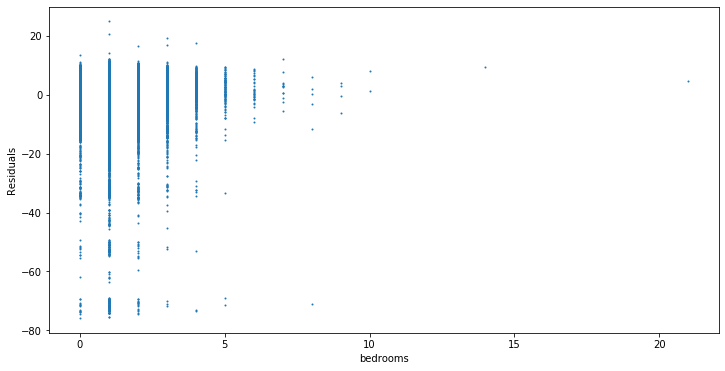

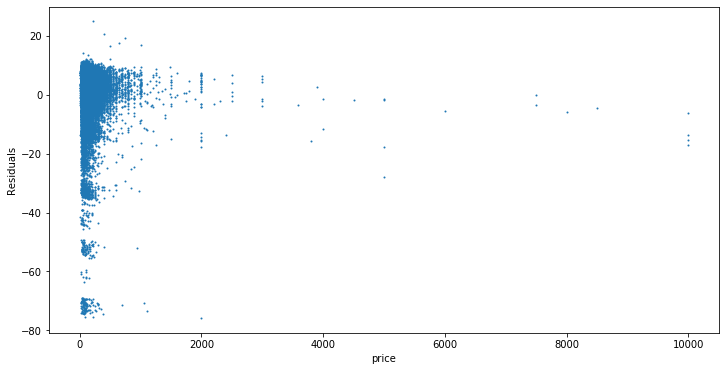

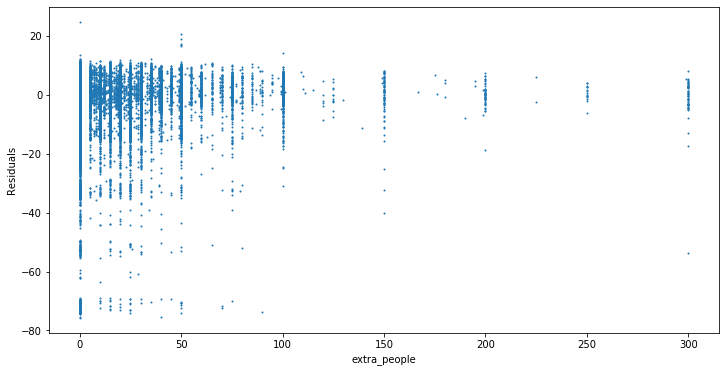

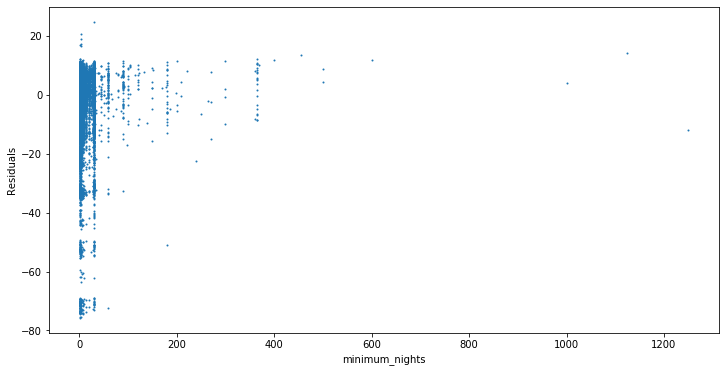

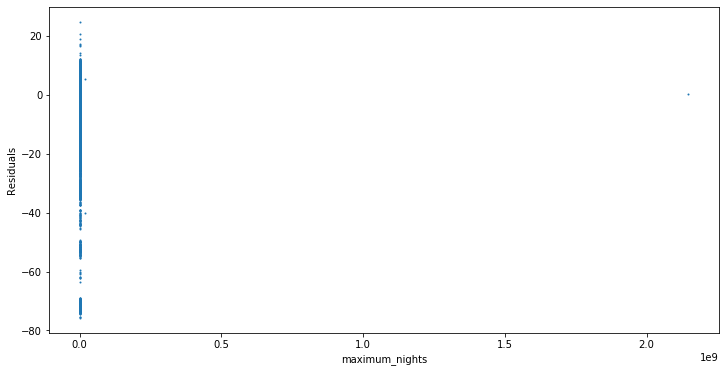

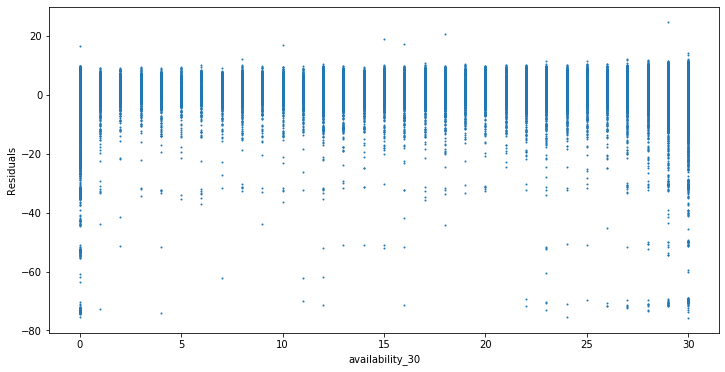

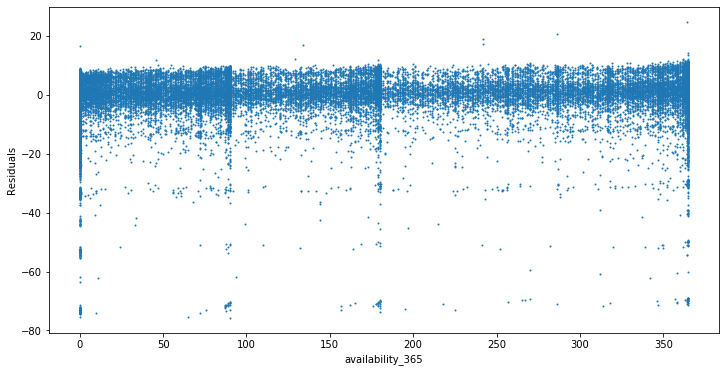

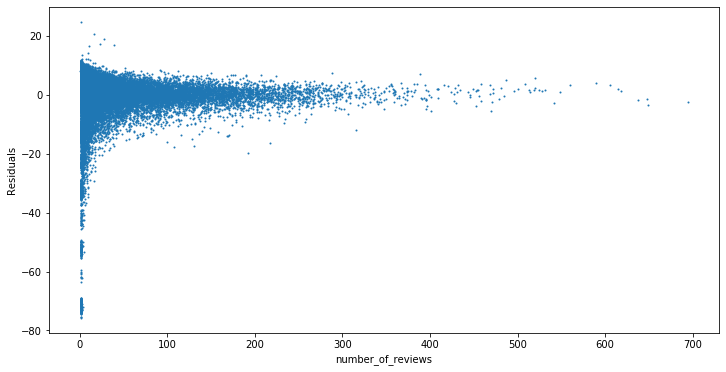

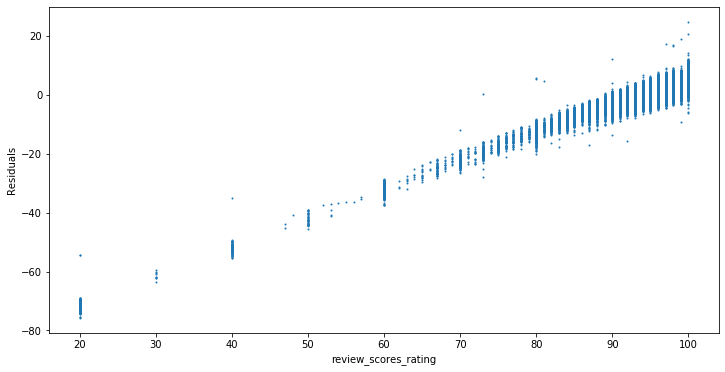

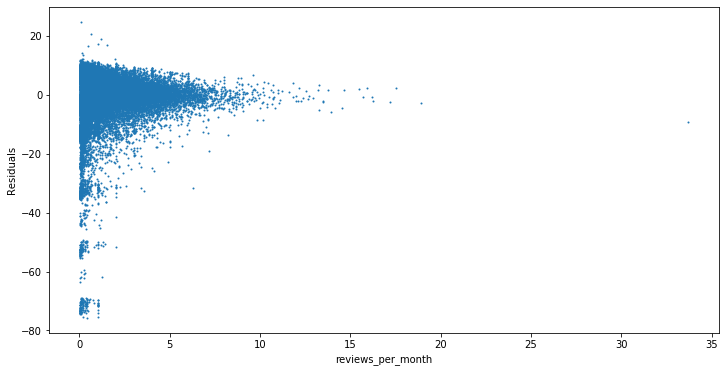

In [76]:
pred_val = fit2.fittedvalues.copy()
true_val = df['review_scores_rating'].values.copy()
residual = true_val - pred_val

for i in df.columns[:10]:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(df[i], residual, s=1)
    plt.xlabel('{}'.format(i))
    plt.ylabel('Residuals')
    plt.show()

- ### Normality of Errors

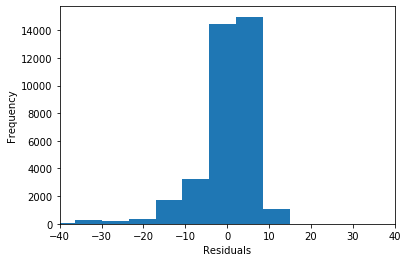

In [43]:
#Histogram of residuals
ax = plt.hist(fit2.resid, 16)
plt.xlim(-40,40)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

- ### Linearity

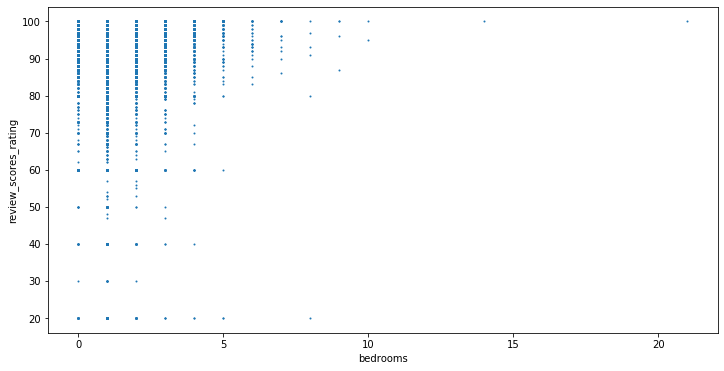

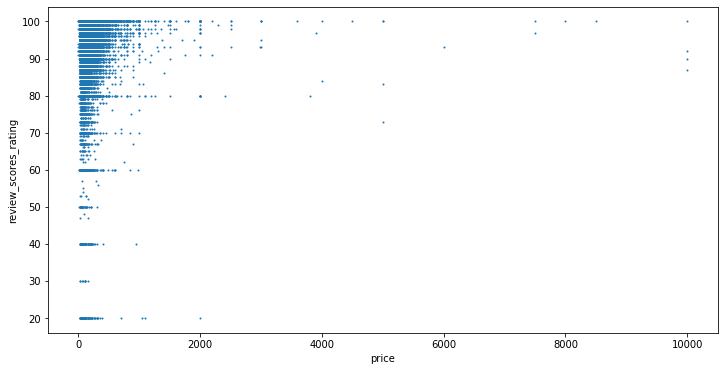

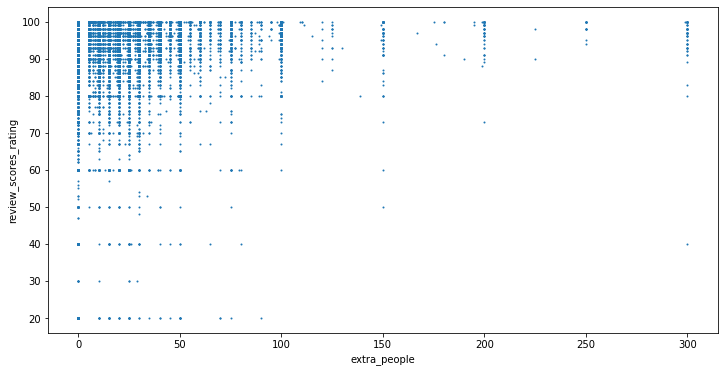

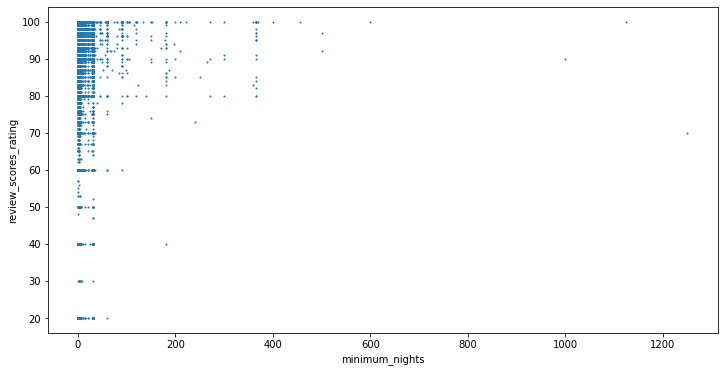

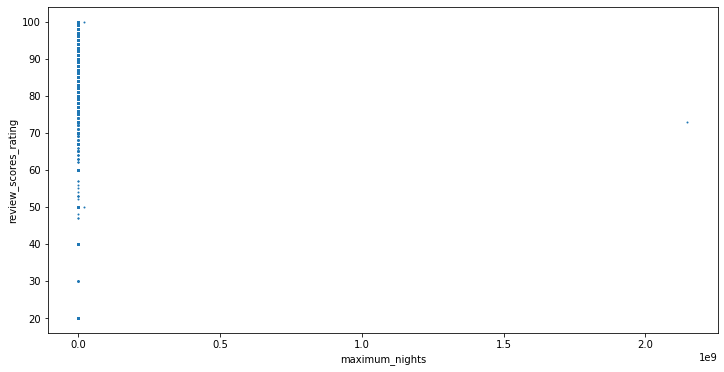

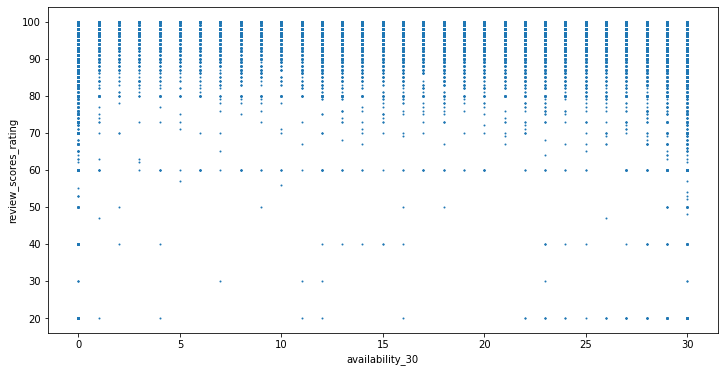

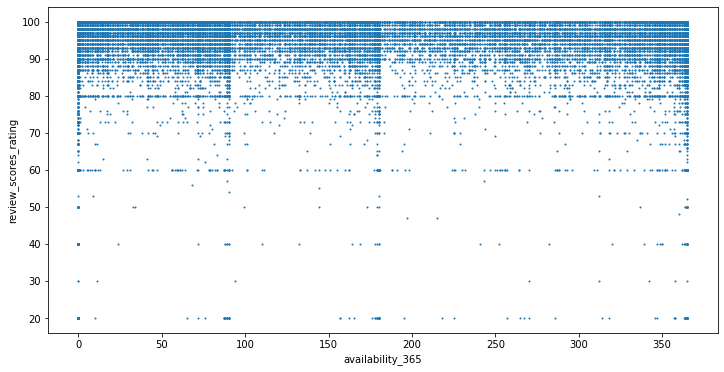

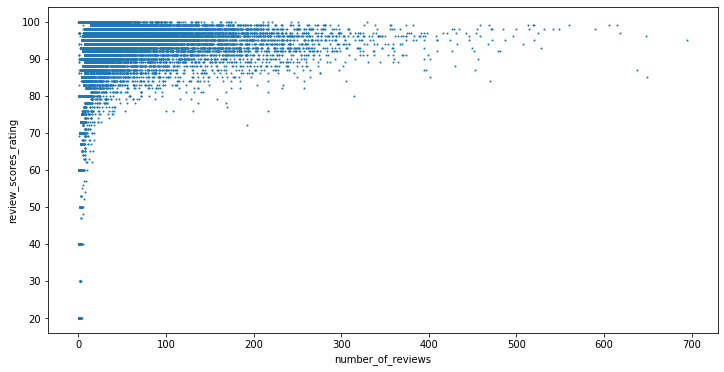

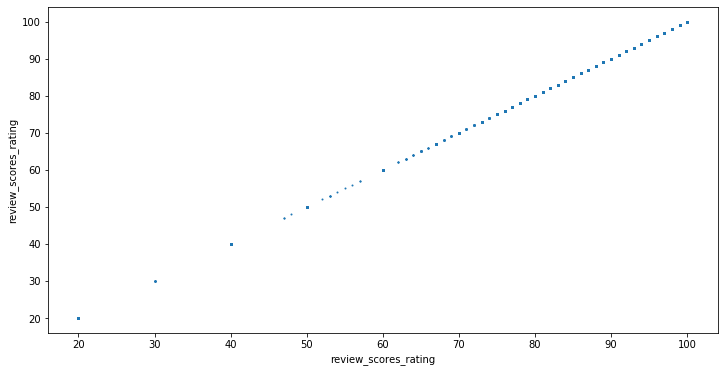

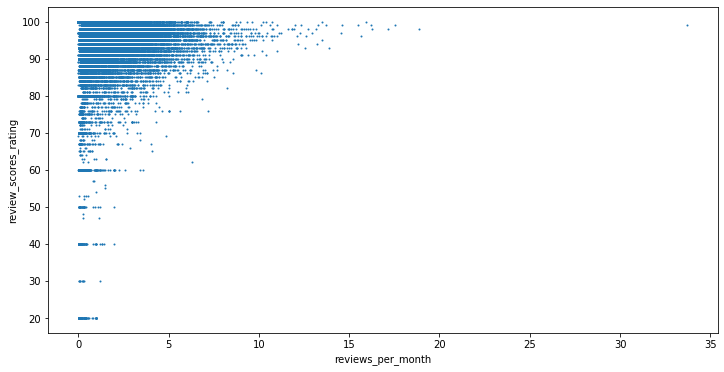

In [79]:
for i in df.columns[:10]:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(df[i], df['review_scores_rating'], s=1)
    plt.xlabel('{}'.format(i))
    plt.ylabel('review_scores_rating')
    plt.show()